# Часть 1. Проверка гипотезы в Python и составление аналитической записки


Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.




- Автор: Родина Дарья 
- Дата: 26 марта 2025 года 

## Цели и задачи проекта

<font> Цель: проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 
    
    Задачи: 
    - Проверить наличие дубликатов в идентификаторах пользователей 
    - Сравнить размеры групп, их статистики и распределение
    - Подготовить аналитическую записку 
</font>

## Описание данных

<font> 
    
    /datasets/yandex_knigi_data.csv' - данные пользователей из Москвы и Санкт-Петербурга. Структура файла: 
    city - город пользователя (Москва или Санкт-Петербург);
    puid - идентификатор пользователя;
    hours - сумма часов активности (чтения или прослушивания аудиофайлов) в приложении.
    
    ps://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов. Структура файла: 
    user_id — идентификатор пользователя;
    group — группа пользователя;
    ab_test — название теста;
    device — устройство, с которого происходила регистрация.

    https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года; Структура файла: 
    user_id — идентификатор пользователя;
    event_dt — дата и время события;
    event_name — тип события;
    details — дополнительные данные о событии.
</font>

## 1. Загрузка данных и знакомство с ними


In [1]:
import pandas as pd 

In [2]:
# создаем новый датафрейм
df = pd.read_csv('/datasets/yandex_knigi_data.csv')

In [3]:
# проверяем датафрейм на наличие пропусков и правильности выбранных типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
df.isna().sum()

Unnamed: 0    0
city          0
puid          0
hours         0
dtype: int64

In [5]:
# проверим данные на наличие дубликатов
duplicate_rows = df.duplicated().sum()
duplicate_rows

0

In [6]:
# проверяем наличие дубликатов в идентификаторах пользователей 
df['puid'].duplicated().sum()

244

In [7]:
# удаляем дубликаты в столбце с идентификаторами пользователей 
df = df.drop_duplicates(subset='puid')

In [8]:
# проверяем наличие дубликатов после удаления
df['puid'].duplicated().sum()

0

В данных отсутсвуют пропуски. Все типы данных соответствуют. При изучении данных в столбце с идентификаторами пользователей были выявлены дубликаты, которые впоследствии были удалены.  

## 2. Проверка гипотезы в Python

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [9]:
#  импортируем библиотеку для визуализии 
import matplotlib.pyplot as plt

In [10]:
# сравним размеры групп
group = df.groupby('city').agg({'puid' : 'count',
                               'hours' : 'mean'})
group

,puid,hours
city,,
Москва,6234,10.881092
Санкт-Петербург,2306,11.264433


Размеры групп пользователей из Москвы и Санкт-Петербурга отличаются в 2,7 раза, в то время как количество часов также отличается в 1.7 раз.  

In [11]:
# формируем метрику для каждой группы 
msk_data = df[df['city'] == 'Москва']['hours']
spb_data = df[df['city'] == 'Санкт-Петербург']['hours']

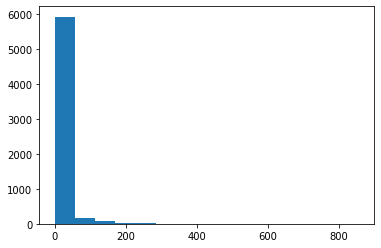

In [12]:
# исследуем распределение для пользователей с Мск
plt.hist(msk_data, bins =15);

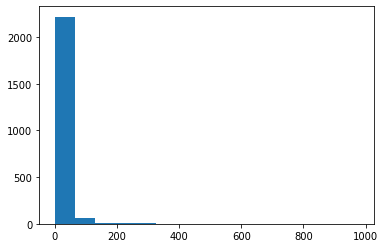

In [13]:
# исследуем распределение для пользователей с СПб
plt.hist(spb_data, bins =15);

На графиках наблюдается правосторонняя, или положительная, асимметрия — правый хвост распределения явно вытянут. Это указывает на присутствие высоких значений, которые оттягивают распределение вправо. 

Исходя из вышеисследуемого, мы не можем использовать параметрические тесты для проверки гипотезы, так как распределение не является нормальным. Именно поэтому далее применим тест Манна-Уитни, который устойчив к выбросам, так как использует ранги, а не абсолютные значения. 

Формулируем гипотезы:

Н0 (нулевая гипотеза): среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Н1 (альтернативная гипотеза): среднее время активности пользователей в Санкт-Петербурге больше, чем в Москве, и это различие статистически значимо. 

In [14]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np 

In [15]:
# применяем тест Манна-Уитни 
alpha = 0.05 
stat_mw, p_value_mw = mannwhitneyu(
    msk_data, 
    spb_data, 
    alternative='greater'
) 
if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза не отвергается! Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза отвергается! Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')

pvalue=0.3810436794993063 > 0.05
Нулевая гипотеза не отвергается! Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


## 3. Аналитическая записка


t-тест был выполнен по типу Манна-Уитни, так как для него не требуется нормальное распределение выборочного среднего. Уровень значимости выбрали 0.05, так как оно самое часто используемое значение в практике. 

По результатам теста средняя активность пользователей в часах в двух группах не различается, то есть нулевая гипотеза находит свое подтверждение, так как в ходе выполнения тестирования значение p-value составляет 0.38, что больше уровня значимости. 

На основе этого эксперимента и имеющихся в нем данных не нашлось достаточных доказательств того, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы. 

Такой результат может объяснять причина, например, технической неполадки в одном из городов. То есть возможные технические проблемы или ограничения в работе приложения в одном из городов могут повлиять на результаты и маскировать реальные различия в поведении пользователей. 

----

# Часть 2. Анализ результатов A/B-тестирования

## Описание данных 

Название теста: interface_eu_test;

Группы: А (контрольная), B (новый интерфейс).

 ps://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов. Структура файла:
 - user_id — идентификатор пользователя;
 - group — группа пользователя;
 - ab_test — название теста;
 - device — устройство, с которого происходила регистрация.
 
 https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года; Структура файла: 
 - user_id — идентификатор пользователя;
 - event_dt — дата и время события;
 - event_name — тип события;
 - details — дополнительные данные о событии: 
      -- registration (регистрация) — стоимость привлечения клиента;
      -- purchase (покупка) — стоимость покупки.
 
 

## 1. Цели исследования.



Цель: проверить гипотезу о том, что в течение 7 дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на 3 процентых значения. 

Задачи: 
- загрузить данные теста;
- проверить корректность его проведения;
- проанализировать полученные результаты.

In [16]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [17]:
# проверяем датафрейм с участниками тестов на типы данных и пропуски в столбцах
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [18]:
# проверяем наличие дубликатов 
participants.duplicated().sum()

0

In [19]:
# проверяем датафрейм с архивными данными за 2020 год 
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [20]:
# приводим к более привычному виду столбец с датой
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [21]:
# проверяем наличие пропусков в датафрейме 
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64

Единственный столбец, который содержит пропуски, — это details. В нем хранятся дополнительные данные о событии, в который попал пользователь. Данная информация не понадобится нам в будущем для решения задач, поэтому ничего не будем делать с пропусками. 

In [22]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Строка GLOBAL означает глобальные события, которые касаются всей системы или компании. Такие строки помогают различать массовые события. 

In [23]:
# проверим наличие дубликатов в датафрейме 
events.duplicated().sum()

36318

In [24]:
# удаляем дубликаты 
events = events.drop_duplicates()
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750968 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     750968 non-null  object        
 1   event_dt    750968 non-null  datetime64[ns]
 2   event_name  750968 non-null  object        
 3   details     244905 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 28.6+ MB


In [25]:
# проверяем равномерность распределения пользователей по группам 
test_group = participants.groupby(['ab_test','group'])['user_id'].nunique()
test_group

ab_test                  group
interface_eu_test        A        5383
                         B        5467
recommender_system_test  A        2747
                         B         928
Name: user_id, dtype: int64

В тесте "interface_eu_test" количество пользователей распределено равномерно по группам и иметтдостаточное количество людей для проведения тестирования. При этом в тесте "recommender_system_test" распределение пользователей по группам абсолютно неравномерное. 

In [27]:
# Находим пользователей, которые попали в оба теста
test_a = participants[participants['ab_test'] == 'interface_eu_test']['user_id']
test_b = participants[participants['ab_test'] == 'recommender_system_test']['user_id']
intersection_test = list(set(test_a) & set(test_b))
intersection_test

['D5DD44281759F7C8',
 'C7750723906C925A',
 'D9128C07E09FF452',
 '8FF91E21E27A330D',
 'D737563A454A419E',
 '207E61D6D4F44D97',
 '7060BB1CBE3BAACC',
 'FABB6D49B11E673F',
 'FB1F9619F8C3CC75',
 'EEA592D3C6F5E5A4',
 '01B9975CAE144B78',
 '983E7021DDC7E0FA',
 '928364C4C9F13FA8',
 'AA5A1803D3FA76B4',
 'CDED0FACF20CA716',
 '6DFDC639B8B85EF7',
 'A847CBD3730F6D41',
 '958426148AFA05C5',
 '4A61A28F35795FD1',
 'AEE24B6142A3C431',
 'DD4352CDCF8C3D57',
 '98720595D29108E9',
 '48CFE37563932DC2',
 '526BA4A669CC6CC2',
 '74EEC94A70685C1E',
 '5A7165E3831CBE75',
 'D2F6FB926A64D196',
 '4803D52DB8782CC2',
 '9E68AB5C5C7FEFF4',
 '9FC882129DBDE625',
 '85521867220EB1E7',
 '604F9F5DB1EB8997',
 'C1760622B65C9B84',
 '04988C5DF189632E',
 'E0DF3060D454B5AF',
 'F507CB8030C885FB',
 '19AC976D25997BE9',
 '4B34A5BD1D1AEF0D',
 '8FC9D1BB3017BE66',
 'CCAF138D12385DF2',
 '0D77D907C24CDAC1',
 'DD9DDDB53DA30E40',
 'E40FA02A8A53F693',
 '79DF9D6EDC7A58CE',
 '2D6A6472D7F46812',
 'F195464E8F2E0267',
 '3C46C1264F52F92C',
 'BF1EB8E6FA3

In [28]:
participants = participants[~participants['user_id'].isin(intersection_test)]

In [30]:
# фильтруем участников по названию теста 
filter_participants = participants.query('ab_test == "interface_eu_test"').reset_index()

In [31]:
# объединяем данные участников и событий 
df = filter_participants.merge(events, on = 'user_id', how = 'inner')
df

,index,user_id,group,ab_test,device,event_dt,event_name,details
0,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN
...,...,...,...,...,...,...,...,...
68069,14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN
68070,14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-28 00:29:10,login,NaN
68071,14524,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45
68072,14524,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN


In [32]:
# строим еще один столбец, где для каждого пользователя во всех строчках минимальное значение 
df['moment_reg'] = df.groupby('user_id')['event_dt'].transform('min')
df.head()

,index,user_id,group,ab_test,device,event_dt,event_name,details,moment_reg
0,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31
1,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31
2,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31
3,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31
4,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31


In [33]:
# находим время совершения события пользователем после регистрации 
df['lifetime'] = df['event_dt'] - df['moment_reg']
df.head()

,index,user_id,group,ab_test,device,event_dt,event_name,details,moment_reg,lifetime
0,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0 days 00:00:18
2,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0 days 00:00:26
3,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0 days 00:01:23
4,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1 days 17:38:04


In [34]:
# фильтруем события, которые произошли за первые 7 дней после регистрации 
df = df[df['lifetime'].dt.days <= 6]
df.head(20)

,index,user_id,group,ab_test,device,event_dt,event_name,details,moment_reg,lifetime
0,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0 days 00:00:18
2,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0 days 00:00:26
3,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0 days 00:01:23
4,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1 days 17:38:04
5,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:36,product_page,NaN,2020-12-07 04:37:31,1 days 17:38:05
6,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:37,product_page,NaN,2020-12-07 04:37:31,1 days 17:38:06
7,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-10 15:23:08,product_page,NaN,2020-12-07 04:37:31,3 days 10:45:37
8,0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-10 15:23:09,product_cart,NaN,2020-12-07 04:37:31,3 days 10:45:38
11,4,001E72F50D1C48FA,A,interface_eu_test,Mac,2020-12-17 15:44:05,registration,-3.61,2020-12-17 15:44:05,0 days 00:00:00


С помощью калькулятора https://www.evanmiller.org/ab-testing/sample-size.html#!30;80;5;3;0  было проведено вычисление выборки. Мы получили значение в виде 3 692 пользоваталей на каждую группу. В нашем случае в каждой группе А/В тестирования больше 5 тысяч человек, что говорит о том, что выборка была проведена правильно для получения статистически значимых результатов. 

In [36]:
# фильтруем события, связанные с покупкой 
purch = df.query('event_name == "purchase"')
purch.head()

,index,user_id,group,ab_test,device,event_dt,event_name,details,moment_reg,lifetime
33,7,0031F1B5E9FBF708,A,interface_eu_test,Android,2020-12-15 18:54:51,purchase,4.99,2020-12-14 00:47:10,1 days 18:07:41
34,7,0031F1B5E9FBF708,A,interface_eu_test,Android,2020-12-15 18:55:50,purchase,4.99,2020-12-14 00:47:10,1 days 18:08:40
51,14,004C58ADE7CA8C4A,B,interface_eu_test,Android,2020-12-20 01:13:34,purchase,4.99,2020-12-18 15:14:53,1 days 09:58:41
53,14,004C58ADE7CA8C4A,B,interface_eu_test,Android,2020-12-20 01:14:57,purchase,4.99,2020-12-18 15:14:53,1 days 10:00:04
57,16,0050F43F34C955F4,A,interface_eu_test,PC,2020-12-13 19:44:29,purchase,499.99,2020-12-13 19:41:56,0 days 00:02:33


In [37]:
# находим количество уникальных пользователей, сделавших покупку 
gr = purch.groupby('group')['user_id'].nunique()
gr

group
A    1377
B    1480
Name: user_id, dtype: int64

In [38]:
# находим общее количество посетителей для каждой группы 
all_user = df.groupby('group')['user_id'].nunique()
all_user

group
A    4952
B    5011
Name: user_id, dtype: int64

In [39]:
# находим долю пользователей, которые сделали покупку, от общего количества посетителей для каждой группы 
perc = round(gr / all_user, 2)
perc

group
A    0.28
B    0.30
Name: user_id, dtype: float64

In [40]:
# считаем относительные изменения 
otnos = round((0.30-0.28)/0.28*100, 2)
otnos

7.14

По предварительным данным можем сказать, что тестовая группа показала увеличение конверсии на 0,02 процента по сравнению с контрольной группой. Относительное улучшение конверсии составило 7,1 процента.

## 4. Оценка результатов A/B-тестирования:

Формулируем гипотезу: 

H0: доли зарегестрированных пользователей совершивших покупку с обновленным и не обновленным интерфейсом не различаются. 

Н1: доля зарегестрированных пользователей совершивших покупку с обновленным интерфейсом больше, чем доля зарегестрированных пользователей совершивших покупку с НЕ обновленным интерфейсом. 

In [41]:
# считаем размеры выборок 
n_a, n_b = df[df.group == "A"]['user_id'].nunique(), df[df.group == "B"]['user_id'].nunique()

# считаем количество успехов (покупок) в группе А и В 
m_a = df[df.group == "A"][df.event_name == "purchase"]['user_id'].nunique()
m_b = df[df.group == "B"][df.event_name == "purchase"]['user_id'].nunique()

# рассчитываем доли успехов для каждой группы 
p_a, p_b = m_a/n_a, m_b/n_b

/tmp/ipykernel_48/2320238348.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m_a = df[df.group == "A"][df.event_name == "purchase"]['user_id'].nunique()
/tmp/ipykernel_48/2320238348.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m_b = df[df.group == "B"][df.event_name == "purchase"]['user_id'].nunique()


In [42]:
# проверяем можем ли мы использовать Z-тест пропорций
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [43]:
# используем Z-тест пропорций 
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' 
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Доли зарегестрированных пользователей совершивших покупку с обновленным и не обновленным интерфейсом не различаются.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Доля зарегестрированных пользователей совершивших покупку с обновленным интерфейсом больше, чем доля зарегестрированных пользователей совершивших покупку с НЕ обновленным интерфейсом.')

pvalue=0.028262547212292124 < 0.05
Нулевая гипотеза не находит подтверждения! Доля зарегестрированных пользователей совершивших покупку с обновленным интерфейсом больше, чем доля зарегестрированных пользователей совершивших покупку с НЕ обновленным интерфейсом.


 На основе статистической проверке гипотез, можно сделать следующие выводы: 
 - Полученный p-value (0.0058) значительно ниже уровня значимости (0.05), что свидетельствует о высокой статистической значимости различий между группами
 - Тест показал, что доля зарегистрированных пользователей, совершивших покупку с обновленным интерфейсом, выше, чем с предыдущим (необновленным) интерфейсом. Это указывает на положительное влияние обновленного интерфейса на поведенческие метрики пользователей. 
 - Результаты указывают на достижение ожидаемого эффекта, поскольку новая версия привела к увеличению доли пользователей, совершивших целевое действие (покупку). 
 

Итоговый вывод

Проведенная работа: 
- формулирование гипотезы 
- предобработка данных 
- проверка корректности проведения А/В-тестирования
- расчет метрик 
- проверка статистической значимости 
- интерпретация результатов и принятие решений 


 Результаты А/В-тестирования демонстрируют, что обновление интерфейса оказало положительное влияние на поведение посетителей, увеличив долю зарегистрированных пользователей, совершивших покупку. Эти изменения имеют высокую статистическую значимость, что делает их эффективными и применимыми для принятия решений.